# Part 1: The impact of regularization

This part highlights the impact of using Ridge Regularization. The required imports are shown in the following cell. The random seed has been set to 42 for reproducibility. Some stylistic settings have been activated to improve the presentation of the graphs.

In [1]:
import math
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn as sk
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
sns.set_context('paper')
sns.set_style('darkgrid')

%matplotlib inline
np.random.seed(42)


<p>The first step is to generate two sets of data. The premise of this exercise is to mimic a real-world situation where the relationship between input and output is affected by noise. To do this, we will add Gaussian noise to a sample of 10 data points from the function y = sin(2πx). To visualize the effect of the noise on the data points, we also generate 100 data points for the continuous function y = sin(2πx)</p>

In [2]:
# Generate datapoints for y = sin (2πx) + noise
x = np.random.random_sample(10)
y_orig = np.sin(2 * math.pi * x)
noise = np.random.normal(0, 0.3, 10)
y_noise = np.sin(2 * math.pi * x) + noise

# Generate Curve for y = sin (2πx)
x2 = np.linspace(0, 1, 100)
y2 = np.sin(2 * math.pi * x2)


<p>Below is the visualization of the original function (orange) along with the noisy datapoints (blue). A low number of data points was selected to clearly demonstrate how fitting regression models with low amounts of data leads to the manifestation of over and under fitting</p>

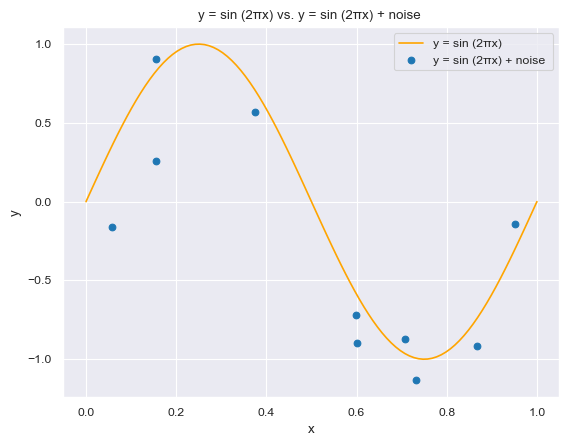

In [3]:
plt.plot(x2, y2, label="y = sin (2πx)", color="orange")
plt.scatter(x, y_noise, label="y = sin (2πx) + noise ")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("y = sin (2πx) vs. y = sin (2πx) + noise ")
plt.show()


<p>For our first model, we will be using linear regression with polynomial features, effectively making a polynomial regression model. The first stage in creating this model is to create the polynomial features. As each data point currently contains an x and y value, the 9 more features are generated by raising the x value to the power of 2, 3, ... 10.<p>

In [4]:
# generate polynomial features up to degree 10
data = pd.DataFrame(
    x, columns=["x"]
)  ## These data points will be using to train the model
for i in range(2, 11):
    colname = "x_%d" % i
    data[colname] = data["x"] ** i

Test_Data = np.linspace(
    np.sort(x)[0], np.sort(x)[-1], num=50
)  # 50 data points that will be used to demonstrate the relationship built by the model (extreme case)
Test_Data = pd.DataFrame(Test_Data, columns=["x"])
for i in range(2, 11):
    colname = "x_%d" % i
    Test_Data[colname] = Test_Data["x"] ** i

data.head()


,x,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,0.374540,0.140280,0.052541,0.019679,0.007370,0.002761,0.001034,3.872458e-04,1.450391e-04,5.432296e-05
1,0.950714,0.903858,0.859310,0.816959,0.776694,0.738414,0.702021,6.674216e-01,6.345272e-01,6.032541e-01
2,0.731994,0.535815,0.392213,0.287098,0.210154,0.153831,0.112604,8.242518e-02,6.033473e-02,4.416466e-02
3,0.598658,0.358392,0.214554,0.128445,0.076895,0.046034,0.027558,1.649807e-02,9.876709e-03,5.912776e-03
4,0.156019,0.024342,0.003798,0.000593,0.000092,0.000014,0.000002,3.510847e-07,5.477576e-08,8.546039e-09


<p>The following code creates 10 subplots, one for each of the polynomial degrees. For each degree, only the associated polynomial terms are used to build the linear regression model (ex. a polynomial degree of 4 uses 4 terms: x1, x2, x3, x4). As seen in these figures, the first two degrees show underfitting whereas degrees 7+ show clear signs of overfitting.</p>

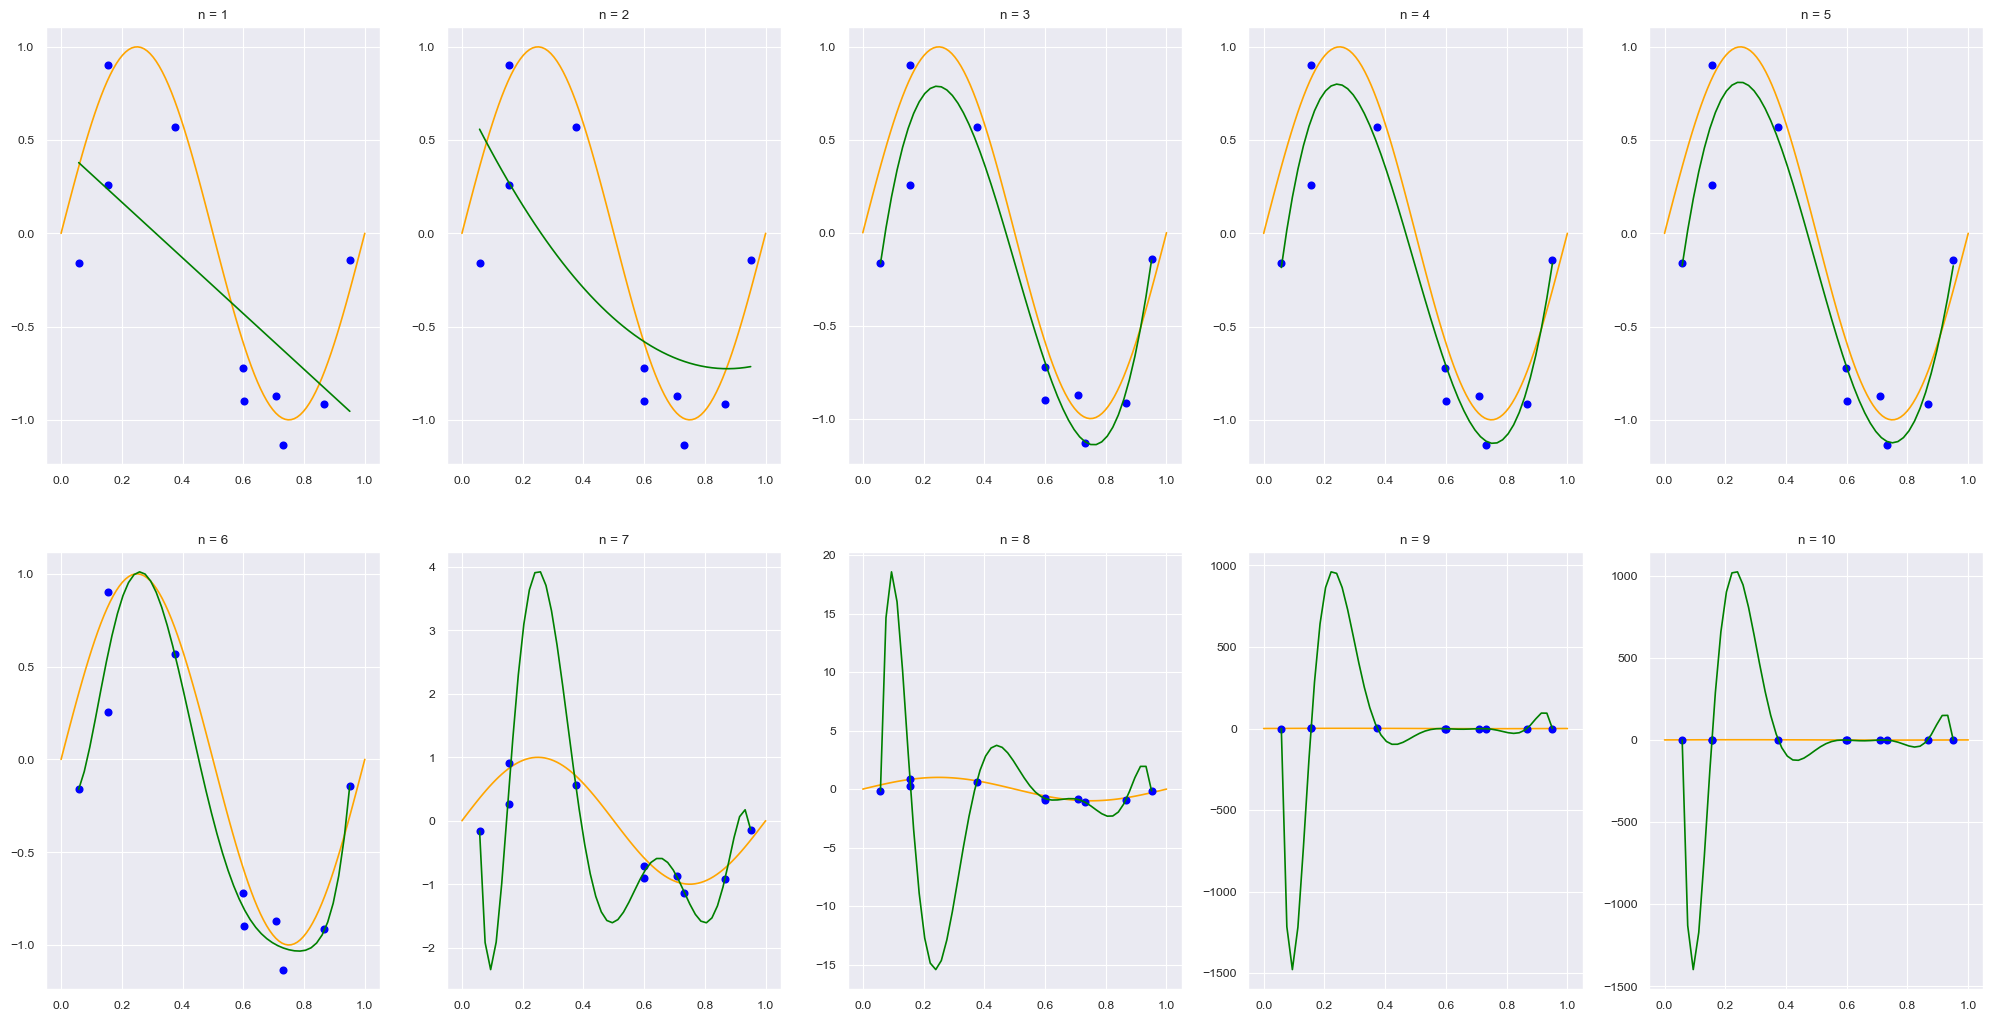

In [5]:
coefs = []  ## Python list
rss = []
fig, axs = plt.subplots(2, 5, figsize=(25, 12.5))
for i in range(0, 2):
    for j in range(0, 5):
        LeastSquaresModel = Pipeline(
            [("scaling", StandardScaler()), ("linreg", LinearRegression())]
        )
        LeastSquaresModel.fit(data.iloc[:, 0 : 5 * i + j + 1], y_noise)
        Test_Data_pred_curve = LeastSquaresModel.predict(
            Test_Data.iloc[:, 0 : 5 * i + j + 1]
        )  ## we applied the model to the 50 data  points
        y_pred_points = LeastSquaresModel.predict(
            data.iloc[:, 0 : 5 * i + j + 1]
        )  ## prediciting of the training data points
        rss.append(np.sum(np.square(y_noise - y_pred_points)))  ## Training RSS
        coefs.append(LeastSquaresModel[1].coef_)  ## Model Coefficients
        axs[i, j].plot(
            x2, y2, label="y = sin (2πx)", color="orange"
        )  ## the sin function
        axs[i, j].plot(
            x, y_noise, "o", color="b"
        )  # the 10 training points (with noise)
        axs[i, j].plot(
            Test_Data.x, Test_Data_pred_curve, color="g"
        )  ## visulization of the model
        axs[i, j].title.set_text("n = " + str(5 * i + j + 1))


<p>As seen above, as the model complexity increases, so too does the level of overfitting. To further illustrate a consequence of the higher-order polynomials, we will explore the coefficients of each model. </p>

In [6]:
# Visualizing Size of Coefficients
coef_mat = pd.DataFrame(coefs)  ## coefficent matrix
pd.options.display.float_format = "{:,.2g}".format
coef_mat.index.name = "polynomial rank"
coef_mat.columns = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10"]
coef_mat


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
polynomial rank,,,,,,,,,,
0,-0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,0.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.8,-13,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.1,-14,9.9,-0.93,NaN,NaN,NaN,NaN,NaN,NaN
4,4.5,-10,0.086,9.3,-3.9,NaN,NaN,NaN,NaN,NaN
5,-3.8,64,-2.6e+02,4.6e+02,-3.7e+02,1.1e+02,NaN,NaN,NaN,NaN
6,-2.1e+02,2.2e+03,-9.5e+03,2.1e+04,-2.6e+04,1.6e+04,-4e+03,NaN,NaN,NaN
7,2e+03,-2.2e+04,1.1e+05,-3.1e+05,5e+05,-4.7e+05,2.4e+05,-5.3e+04,NaN,NaN
8,-2e+05,2.4e+06,-1.4e+07,4.4e+07,-8.9e+07,1.1e+08,-8.9e+07,3.9e+07,-7.4e+06,NaN


<p>What we have observed above is known as coefficient explosion (magnitude of coefficients increases exponentially as model complexity increases) and is a key indication of overfitting. To further verify this, we will plot the Residual Sum of Squares (RSS) for each of the polynomial degrees. As seen in this plot, the highest rank polynomials have an RSS of 0 as they fit each point.</p>

Text(0.5, 1.0, 'The effect of Polynomial Rank on RSS')

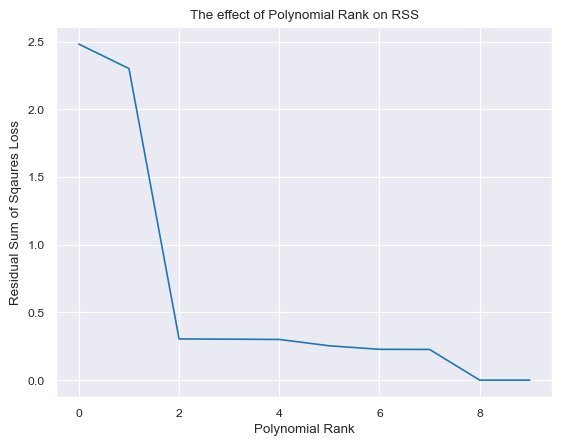

In [7]:
plt.plot(rss)
plt.xlabel("Polynomial Rank")
plt.ylabel("Residual Sum of Sqaures Loss")
plt.title("The effect of Polynomial Rank on RSS")


<p>To illustrate coefficient explosion, we plot the mean absolute magnitude of the coefficients for each of the polynomial ranks. As seen, the average magnitude of the coefficient drastically increases with model complexity.</p>

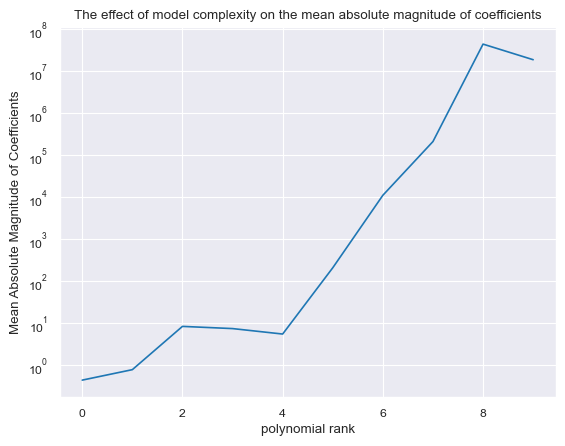

In [8]:
abs(coef_mat).mean(axis=1).plot(logy=True)
plt.ylabel("Mean Absolute Magnitude of Coefficients")
plt.title(
    "The effect of model complexity on the mean absolute magnitude of coefficients"
)
plt.show()


To mitigate the effect of overfitting with respect to polynomial rank, Ridge Regression is used. As you know, in terms of Ridge Regression, the α parameter defines the level of regularization; an α of 0 indicates no regularization whereas an $α$ approaching $\infty $ indicates full regularization and reduces all coefficients to 0. The following code illustrates the effect of this regularization on the 10 term polynomial developed above.

/Users/parm/anaconda3/envs/DSenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.70307e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


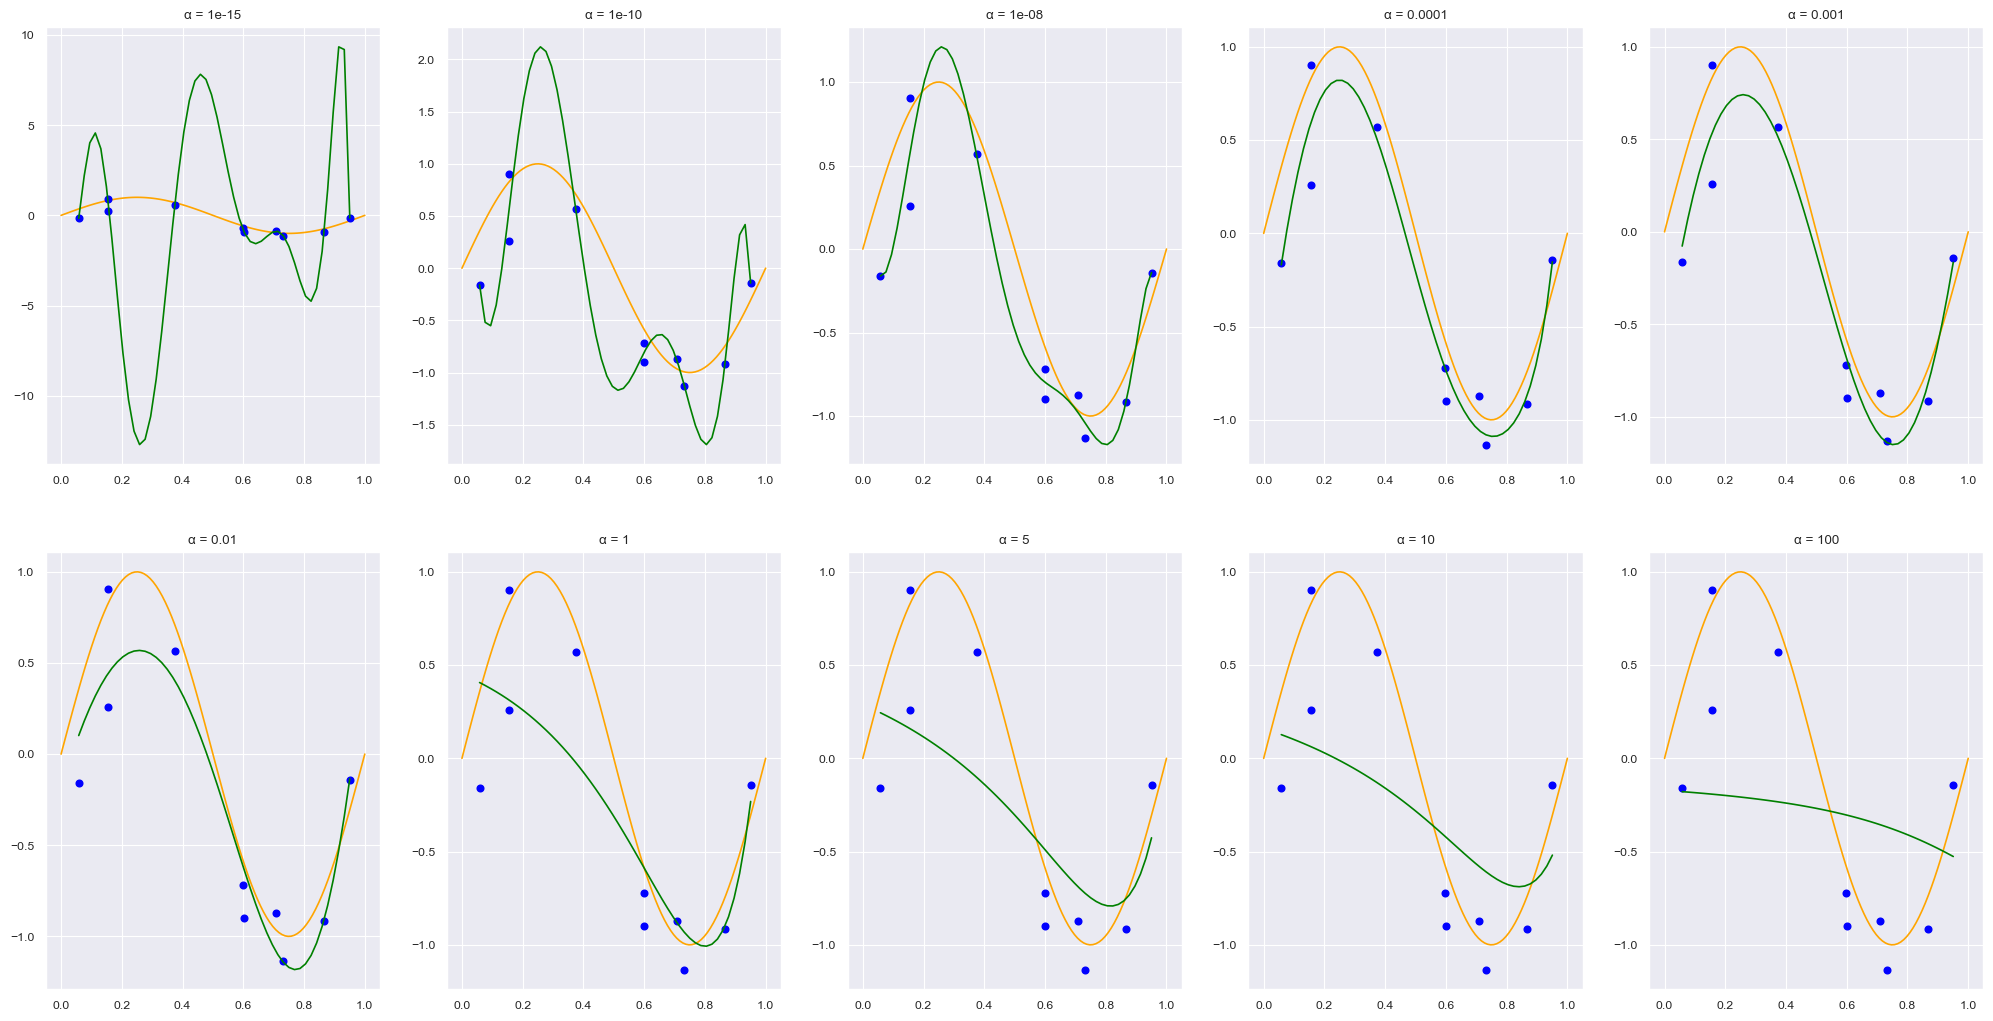

In [9]:
coefs = []
rss = []
fig, axs = plt.subplots(2, 5, figsize=(25, 12.5))
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 100]
for i in range(0, 2):
    for j in range(0, 5):
        RidgeModel = Pipeline(
            [
                ("scaling", StandardScaler()),
                ("ridge_reg", Ridge(alpha=alphas[5 * i + j])),
            ]
        )
        RidgeModel.fit(data, y_noise)  # training the model using the 10 data points
        TestData_pred_curve = RidgeModel.predict(
            Test_Data
        )  ## Model applied to the test data
        y_pred_points = RidgeModel.predict(data)  ## Model applied on the traing data
        rss.append(np.sum(np.square(y_noise - y_pred_points)))  ## training RSS
        coefs.append(RidgeModel[1].coef_)
        axs[i, j].plot(
            x2, y2, label="y = sin (2πx)", color="orange"
        )  ## the sin function
        axs[i, j].plot(x, y_noise, "o", color="b")  # plot the 10 training data points
        axs[i, j].plot(
            Test_Data.x, TestData_pred_curve, color="g"
        )  # plot the predicted ouput of the 50 test data points
        axs[i, j].title.set_text("α = " + str(alphas[5 * i + j]))


<p>As seen above, as the value of α increases, there is a transition from overfitting to underfitting. This shows the power of regression to reverse the effects of overfitting but also highlights the importance of appropriately affecting the α value as too high of a value results in severe underfitting. We can see the effect through the size of coefficients for the various values of α below. </p>

In [10]:
coef_mat = pd.DataFrame(coefs)
pd.options.display.float_format = "{:,.2g}".format
coef_mat.index = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 100]
coef_mat.index.name = "alpha"
coef_mat.columns = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10"]
coef_mat


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
alpha,,,,,,,,,,
1e-15,-2.9e+02,6.4e+03,-5.4e+04,2.2e+05,-4.3e+05,3e+05,3.4e+05,-8e+05,5.8e+05,-1.5e+05
1e-10,-42,3.9e+02,-1.2e+03,1e+03,7.2e+02,-8.5e+02,-1.1e+03,3.7e+02,1.6e+03,-9.2e+02
1e-08,-9.1,1e+02,-3.3e+02,3e+02,1.9e+02,-2.3e+02,-2.7e+02,1e+02,3.6e+02,-2.1e+02
0.0001,4.2,-8.4,-2.5,4.8,5.5,1.5,-3.1,-4.8,-2.3,4.9
0.001,3.2,-6.1,-1.3,2.1,2.4,1.1,-0.26,-1,-0.75,0.51
0.01,1.7,-2.8,-1.5,0.091,0.93,1.1,0.82,0.35,-0.18,-0.69
1,-0.21,-0.33,-0.26,-0.14,-0.036,0.047,0.11,0.15,0.19,0.21
5,-0.22,-0.19,-0.13,-0.069,-0.017,0.025,0.057,0.081,0.1,0.12
10,-0.16,-0.14,-0.094,-0.051,-0.016,0.012,0.034,0.05,0.063,0.074


The following is a visualization of the ridge where we can see the size of the coefficients drastically dropping and approaching zero as α approaches $\infty$.

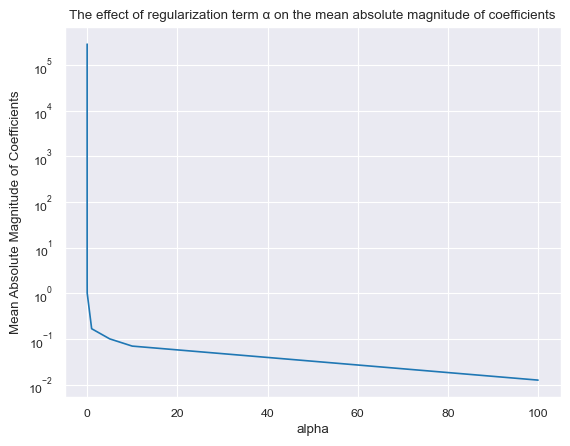

In [11]:
abs(coef_mat).mean(axis=1).plot(logy=True)
plt.ylabel("Mean Absolute Magnitude of Coefficients")
plt.title(
    "The effect of regularization term α on the mean absolute magnitude of coefficients"
)
plt.show()


# Part 2: Feature expansion and regularization

This part highlights feature expansion and the different regularization techniques.

## Polynomial expansion 

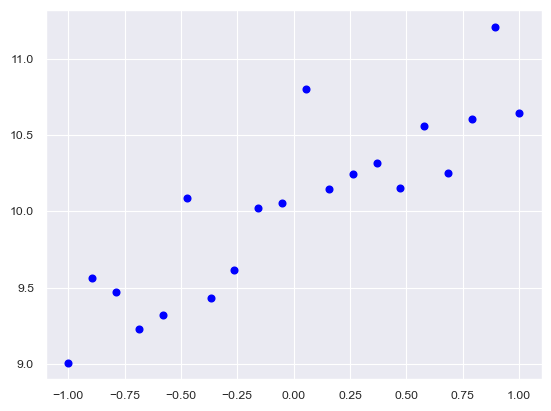

In [12]:
# Let's load a data set and look at it.
D = pd.read_csv("regression_data.csv")
plt.plot(D.x, D.y, "bo")
plt.show()


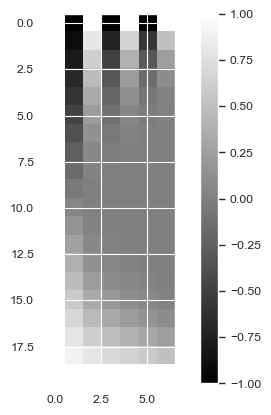

,0,1,2,3,4,5,6
0,1,-1,1,-1,1,-1,1
1,1,-0.89,0.8,-0.72,0.64,-0.57,0.51
2,1,-0.79,0.62,-0.49,0.39,-0.31,0.24
3,1,-0.68,0.47,-0.32,0.22,-0.15,0.1
4,1,-0.58,0.34,-0.19,0.11,-0.065,0.038


In [13]:
# Build a design matrix with polynomial expansion on X
x = D.x.values
x = x.reshape(-1, 1)
poly = sk.preprocessing.PolynomialFeatures(degree=6)
X = poly.fit_transform(x)


plt.imshow(X, cmap="gray")  # drop the cmap flag to get color
plt.colorbar()
plt.show()

XDF = pd.DataFrame(X)
XDF.head()


## Ridge regression

(7,)


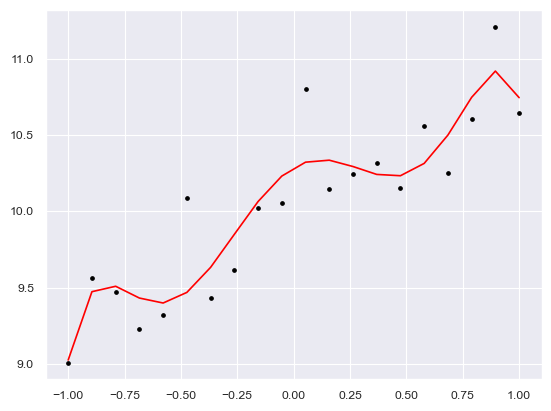

In [14]:
# Now fit a standard linear model to the data and plot prediction
reg = skl.LinearRegression(fit_intercept=False)
reg.fit(X, D.y)
yp = reg.predict(X)

print(reg.coef_.shape)

plt.plot(x, D.y, "k.", x, yp, "r-")
plt.show()


Coef. matrix shape (7 x 1)


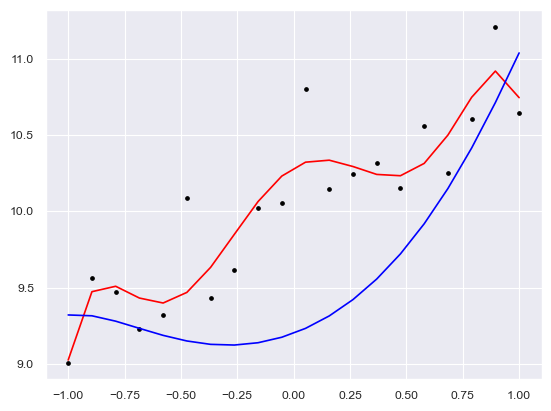

In [15]:
# This seems very wiggly.
# Could we do better with Ridge regression?
# Let's regularize a lot
print("Coef. matrix shape (%i x 1)" % reg.coef_.shape)

ridge = skl.Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(X, D.y)
ypp = ridge.predict(X)

plt.plot(x, D.y, "k.", x, yp, "r-", x, ypp, "b-")
plt.show()


### Fix the intercept problem

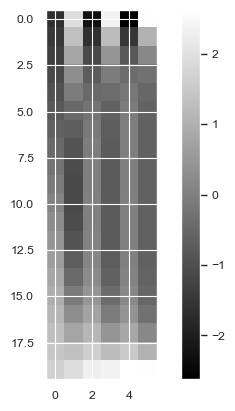

In [16]:
# What happened?
# The problem is that the Ridge coefficient was also applied to the intercept
# Sometimes this is desired, sometimes not. (Usually not though)
# In this case we do not want to include the intercept
# into the regressors that should be regularized
poly = sk.preprocessing.PolynomialFeatures(6, include_bias=False)
X = poly.fit_transform(x)
scaler = sk.preprocessing.StandardScaler(with_mean=True, with_std=True)

X = scaler.fit_transform(X)

pd.DataFrame(X).head()
plt.imshow(X, cmap="gray")

plt.colorbar()
plt.show()


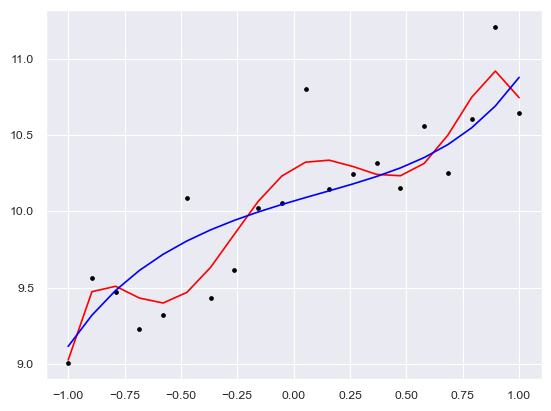

In [17]:
# If we set fit_intercept = True (default),
# ridge regression fits the intercept
ridge = skl.Ridge(alpha=5.0, fit_intercept=True)
ridge.fit(X, D.y)
ypp = ridge.predict(X)

plt.plot(x, D.y, "k.", x, yp, "r-", x, ypp, "b-")
plt.show()


In [18]:
# Also redo the linear regression
reg = skl.LinearRegression(fit_intercept=True)
reg.fit(X, D.y)


LinearRegression()

In [19]:
# Now inspect the coefficients: No explicit intercept is fitted - ridge coefficients are smaller
(reg.coef_, ridge.coef_)


(array([ 0.5259425 , -1.22248473, -0.14851093,  2.98075495,  0.12675624,
        -1.85398615]),
 array([ 0.26264477, -0.03604224,  0.12595432,  0.01336734,  0.06098453,
        -0.0009332 ]))

### How to set the regularization coefficent? 

In [20]:
# So, how should we tune the regularization coefficient?
# Let's use crossvalidation
cv_scores = cross_val_score(
    skl.LinearRegression(), X, D.y, cv=5, scoring="neg_mean_squared_error"
)
-cv_scores


array([2.59262227e+02, 2.40636938e-01, 9.21051190e-02, 1.01115077e-01,
       7.09633014e+01])

In [21]:
# Systematically vary the ridge coeficient on a log-scale
lam = np.exp(np.linspace(-4, 2, 10))
mse = np.zeros(10)

for i in range(lam.size):
    cv_scores = cross_val_score(
        skl.Ridge(alpha=lam[i]), X, D.y, cv=5, scoring="neg_mean_squared_error"
    )
    mse[i] = -cv_scores.mean()


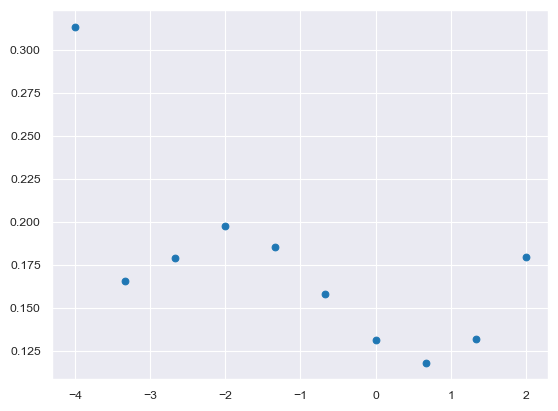

In [22]:
# Determine lowest value
plt.scatter(np.log(lam), mse)
plt.show()


In [23]:
# So low let's look at the crossvalidation error for the best setting of lambda
cv_scores = cross_val_score(skl.Ridge(alpha=np.exp(0.8)), X, D.y, cv=5)

print("CV score for alpha=exp(0.8): %.3f" % -cv_scores.mean())


CV score for alpha=exp(0.8): 0.443


## Lasso 

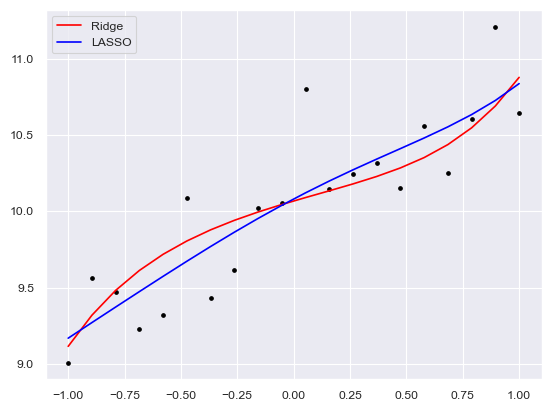

In [24]:
las = skl.Lasso(alpha=0.005, fit_intercept=True)
las.fit(X, D.y)
yl = las.predict(X)

plt.plot(x, D.y, "k.", label="_nolegend_")
plt.plot(x, ypp, "r-", label="Ridge")
plt.plot(x, yl, "b-", label="LASSO")
plt.legend()
plt.show()


In [25]:
# Let's check the coefficients.
# What do you notice compared to the ridge?
pd.DataFrame({"Ridge": ridge.coef_, "LASSO": las.coef_})

# Ridge shrinks all coefficients towards zero; the lasso tends to give
# a set of zero coefficients and leads to a sparse solution.
# Note that for both ridge regression and the lasso the regression coefficients
# can move from positive to negative values as they are shrunk toward zero.


,Ridge,LASSO
0,0.26,0.47
1,-0.036,-0.066
2,0.13,0
3,0.013,0.039
4,0.061,0.022
5,-0.00093,0


### Lasso Path 

minimum regularization parameter : 0.002
maximum regularization parameter : 0.494


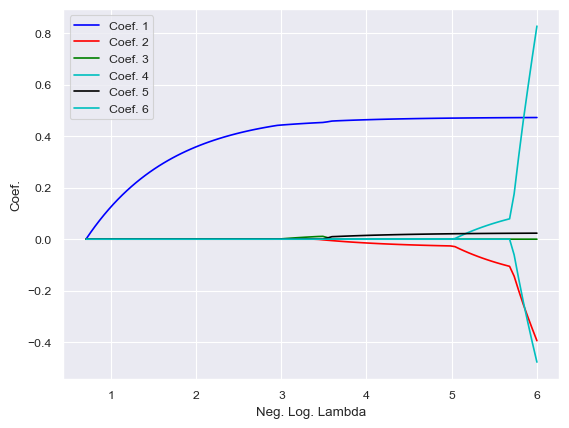

In [26]:
# Get a full path for Lasso
eps = 5e-3  # The smaller eps, the longer the path
lambda_lasso, coefs_lasso, _ = skl.lasso_path(
    X, D.y, eps=eps, n_alphas=100, alphas=None
)

print(f"minimum regularization parameter : %.3f" % np.amin(lambda_lasso))
print(f"maximum regularization parameter : %.3f" % np.amax(lambda_lasso))
# plt.plot(lambda_lasso)


colors = ["b", "r", "g", "c", "k", "c"]
neg_log_lambda = -np.log(lambda_lasso)

for i in range(6):
    l1 = plt.plot(neg_log_lambda, coefs_lasso[i,], c=colors[i])

plt.xlabel("Neg. Log. Lambda")
plt.ylabel("Coef.")
plt.legend(["Coef. 1", "Coef. 2", "Coef. 3", "Coef. 4", "Coef. 5", "Coef. 6"])
plt.show()


## ElasticNet (and automatic search for best hyperparameters)

In [27]:
# Create ElasticNet object
ElasticNet = skl.ElasticNetCV(
    eps=eps,
    n_alphas=10,
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    alphas=None,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    cv=3,
    n_jobs=2,
    random_state=20220214,
)


In [28]:
# Fit it
ElasticNet.fit(X, D.y)


ElasticNetCV(cv=3, eps=0.005, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             n_alphas=10, n_jobs=2, random_state=20220214, tol=0.001)

In [29]:
# Print best coefficients
print(f"Best fit: alpha={round(ElasticNet.alpha_, 3)}, l1_ratio={ElasticNet.l1_ratio_}")


Best fit: alpha=0.006, l1_ratio=0.7


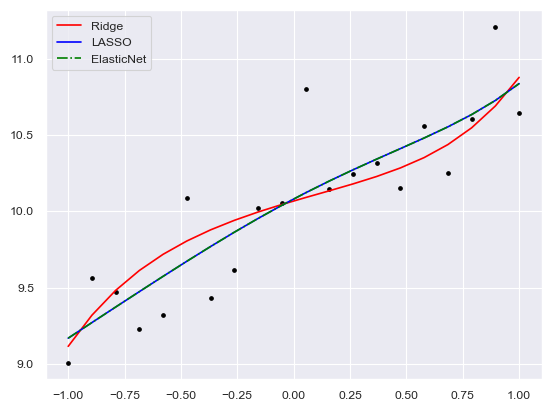

In [30]:
# Plot fit
yen = las.predict(X)

plt.plot(x, D.y, "k.", label="_nolegend_")
plt.plot(x, ypp, "r-", label="Ridge")
plt.plot(x, yl, "b-", label="LASSO")
plt.plot(x, yen, "g-.", label="ElasticNet")
plt.legend()
plt.show()


In [31]:
# Compare coefficients
pd.DataFrame({"Ridge": ridge.coef_, "LASSO": las.coef_, "ElasticNet": ElasticNet.coef_})


,Ridge,LASSO,ElasticNet
0,0.26,0.47,0.47
1,-0.036,-0.066,-0.073
2,0.13,0,0
3,0.013,0.039,0.047
4,0.061,0.022,0.025
5,-0.00093,0,-0
